In [2]:
import os
import glob
import pickle
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Rectangle

TEST_DATA_DIR = "/common/users/dm1487/namo_data/idfs_train_set/sep25/medium/goal_proximity_hard_goal_discretized_skill15"
RESULT_FILES = []
RESULT_FILES += glob.glob(f"{TEST_DATA_DIR}/modular_data_*/**/*_results.pkl", recursive=True)
len(RESULT_FILES)


239

In [3]:
def load_worker_results(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    # Expected top-level keys: task_id, success, episode_results (list of dicts)
    eps = data.get('episode_results', [])
    return eps


def pick_episode(episodes):
    # Choose any episode that has plotted trajectory fields
    candidates = []
    for ep in episodes:
        states = ep.get('state_observations')
        actions = ep.get('action_sequence')
        if states and len(states) > 0 and actions and len(actions) > 0:
            candidates.append(ep)
    if not candidates:
        return None
    return random.choice(candidates)


def calculate_environment_bounds(static_objects):
    min_x, max_x = float('inf'), float('-inf')
    min_y, max_y = float('inf'), float('-inf')
    if not static_objects:
        return -3.2, 3.2, -3.2, 3.2
    for obj_name, obj_info in static_objects.items():
        if obj_name.startswith('wall_'):
            x = obj_info['pos_x']
            y = obj_info['pos_y']
            w = obj_info['size_x'] * 2
            h = obj_info['size_y'] * 2
            left = x - w/2
            right = x + w/2
            bottom = y - h/2
            top = y + h/2
            min_x = min(min_x, left)
            max_x = max(max_x, right)
            min_y = min(min_y, bottom)
            max_y = max(max_y, top)
    if not all(map(lambda v: v not in [float('inf'), float('-inf')], [min_x, max_x, min_y, max_y])):
        return -3.2, 3.2, -3.2, 3.2
    margin = 0.2
    return min_x - margin, max_x + margin, min_y - margin, max_y + margin


def plot_environment_state(ax, state_obs, static_objects, robot_goal, action=None, title="Environment State"):
    ax.clear()
    ax.set_aspect('equal')
    ax.set_title(title)

    if static_objects:
        for obj_name, obj_info in static_objects.items():
            if obj_name.startswith('wall_'):
                x = obj_info['pos_x']
                y = obj_info['pos_y']
                w = obj_info['size_x'] * 2
                h = obj_info['size_y'] * 2
                rect = Rectangle((x - w/2, y - h/2), w, h, facecolor='gray', edgecolor='black', alpha=0.8)
                ax.add_patch(rect)

    if state_obs:
        for key, pose in state_obs.items():
            if key.endswith('_movable_pose'):
                obj_name = key.replace('_pose', '')
                if static_objects and obj_name in static_objects:
                    x, y, theta = pose[:3]
                    w = static_objects[obj_name]['size_x'] * 2
                    h = static_objects[obj_name]['size_y'] * 2
                    rect = Rectangle((x - w/2, y - h/2), w, h, facecolor='yellow', edgecolor='black', alpha=0.8)
                    if theta != 0:
                        from matplotlib.transforms import Affine2D
                        t = Affine2D().rotate_around(x, y, theta) + ax.transData
                        rect.set_transform(t)
                    ax.add_patch(rect)

    if state_obs and 'robot_pose' in state_obs:
        robot_pos = state_obs['robot_pose'][:2]
        circle = Circle(robot_pos, 0.15, facecolor='blue', edgecolor='black', alpha=0.8)
        ax.add_patch(circle)

    if robot_goal:
        goal_pos = robot_goal[:2]
        circle = Circle(goal_pos, 0.15, facecolor='green', edgecolor='black', alpha=0.8)
        ax.add_patch(circle)

    if action and 'object_id' in action and 'target' in action and static_objects:
        obj_id = action['object_id']
        target_x, target_y, target_theta = action['target'][:3]
        if obj_id in static_objects:
            w = static_objects[obj_id]['size_x'] * 2
            h = static_objects[obj_id]['size_y'] * 2
            rect = Rectangle((target_x - w/2, target_y - h/2), w, h, facecolor='green', edgecolor='black', alpha=0.7)
            if target_theta != 0:
                from matplotlib.transforms import Affine2D
                t = Affine2D().rotate_around(target_x, target_y, target_theta) + ax.transData
                rect.set_transform(t)
            ax.add_patch(rect)

    min_x, max_x, min_y, max_y = calculate_environment_bounds(static_objects)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.grid(True, alpha=0.3)


def plot_episode_sequence(ep_result):
    states = ep_result.get('state_observations') or []
    actions = ep_result.get('action_sequence') or []
    post_action_states = ep_result.get('post_action_state_observations') or []
    static_objects = ep_result.get('static_object_info') or {}
    robot_goal = ep_result.get('robot_goal')

    num_actions = len(actions)
    num_plots = max(1, num_actions + 1)

    cols = min(4, num_plots)
    rows = (num_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if num_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flat if hasattr(axes, 'flat') else axes

    for i in range(num_actions):
        if i < len(axes_flat):
            si = states[i] if i < len(states) else None
            ai = actions[i]
            plot_environment_state(
                axes_flat[i],
                si,
                static_objects,
                robot_goal,
                ai,
                title=f"Step {i+1}: State + Action"
            )

    if num_actions < len(axes_flat):
        final_state = None
        if post_action_states:
            final_state = post_action_states[-1]
        elif states:
            final_state = states[-1]
        plot_environment_state(
            axes_flat[num_actions],
            final_state,
            static_objects,
            robot_goal,
            None,
            title="Final State (Post-Action)"
        )

    for i in range(num_plots, len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.tight_layout()
    plt.show()


Using: /common/users/dm1487/namo_data/idfs_train_set/sep25/medium/goal_proximity_hard_goal_discretized_skill15/modular_data_ilab1/ilab1_env_000112_results.pkl
episodes: 5
episode keys: ['action_sequence', 'algorithm', 'algorithm_stats', 'algorithm_version', 'episode_id', 'error_message', 'failure_code', 'failure_description', 'max_depth_reached', 'nodes_expanded', 'original_action_sequence', 'original_post_action_state_observations', 'original_state_observations', 'post_action_state_observations', 'robot_goal', 'search_time_ms', 'smoothing_stats', 'solution_depth', 'solution_found', 'state_observations', 'static_object_info', 'success', 'terminal_checks', 'xml_file']
{'original_length': 5, 'smoothed_length': 4, 'reduction_ratio': 0.2, 'subsequences_tested': 12, 'smoothing_time': 57.8916871547699}


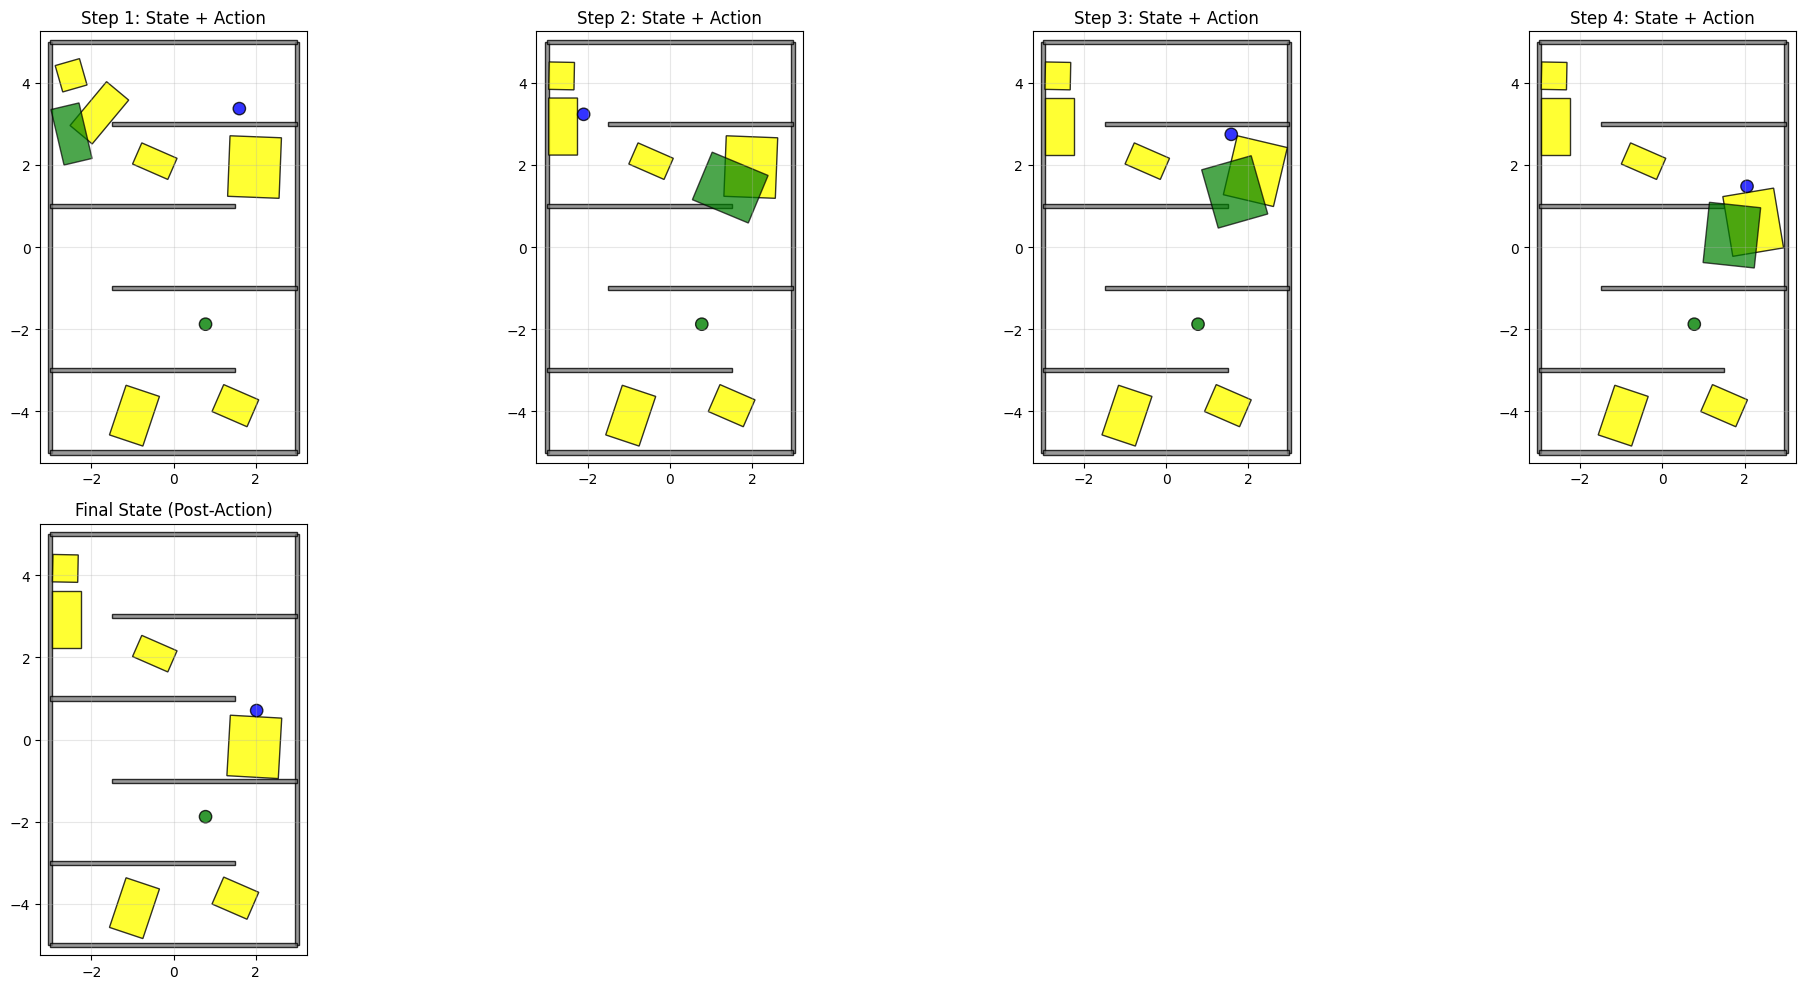

In [8]:
assert len(RESULT_FILES) > 0, "No result files found in test directory"

# Prefer files whose name suggests smoothing; otherwise any results file
def find_file_with_episode(paths, max_scan=200):
    pool = paths[:]
    random.shuffle(pool)
    pool = pool[:max_scan]
    for pth in pool:
        eps = load_worker_results(pth)
        if pick_episode(eps) is not None:
            return pth, eps
    return None, None

# Scan all result files (no preference for smoothed names)
pkl_path, episodes = find_file_with_episode(RESULT_FILES, max_scan=min(400, len(RESULT_FILES)))
if pkl_path is None:
    raise RuntimeError("Could not find any file containing an episode with state_observations and action_sequence")

print("Using:", pkl_path)
print("episodes:", len(episodes))
if episodes:
    print("episode keys:", sorted(episodes[0].keys()))

chosen = pick_episode(episodes)
print(chosen['smoothing_stats'])
plot_episode_sequence(chosen)
